In [1]:
import pandas as pd
import geopandas as gpd
import uuid
import matplotlib.pyplot as plt
import re
from math import ceil
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from shapely import wkt

---
# <b>1. Create synthesized PFT table<b>

In [2]:
# pft_fcover
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
pft_dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_standard_pft_fcover.csv'
    df = pd.read_csv(path, index_col=0)
    pft_dfs.append(df)
pft_fcover = pd.concat(pft_dfs)
    
# rename columns for ESS-Dive
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

# adjust column names and index
pft_fcover.columns = [camel_to_snake(col) for col in pft_fcover.columns]
pft_fcover.index.name = 'unit_id'

# export
pft_fcover = pft_fcover.replace({None: -999, '':-999, np.nan:-999})
pft_fcover.to_csv('synthesized_pft_fcover.csv', index=True)

In [3]:
pft_fcover.head(3)

,deciduous_shrub_cover,deciduous_tree_cover,evergreen_shrub_cover,evergreen_tree_cover,forb_cover,graminoid_cover,nonvascular_sum_cover,bryophyte_cover,lichen_cover,litter_cover,other_cover,water_cover,bareground_cover
unit_id,,,,,,,,,,,,,
120712b1,32.45,0.0,20.52,0.0,2.64,19.20,33.09,31.77,1.32,18.54,0.0,0.0,0.00
120713a1,0.00,0.0,0.00,0.0,1.96,28.75,37.25,36.60,0.65,77.78,0.0,0.0,11.11
120713b1,11.34,0.0,38.01,0.0,0.00,14.66,26.00,17.34,8.66,32.67,0.0,0.0,0.00


---
# 2. Create synthesized plot information (aux) table

## 2.a. Concatenate individual plot info tables

In [4]:
# pft_fcover
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
aux_dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_plot_info.csv'
    df = pd.read_csv(path, index_col=0)
    aux_dfs.append(df)
aux = pd.concat(aux_dfs)

# set data types
intcols = ['surveyYear', 'surveyMonth', 'surveyDay', 'bioclimSubzone']
for col in intcols:
    aux[col] = aux[col].astype('Int64')

# adjust column names and index
aux.columns = [camel_to_snake(col) for col in aux.columns]
aux.index.name = 'unit_id'
    
aux.to_csv('survey_unit_information_temp.csv')

## 2.b. Fill in missing plot information variables manually
Save as `standardized_plot_information.csv`
- Some rows missing admin_unit, admin_country, bioclim_subzone

## 2.c. Summarize final plot information table

#### Columns

In [5]:
aux = pd.read_csv('survey_unit_information.csv')
aux.columns

Index(['unit_id', 'survey_year', 'survey_month', 'survey_day', 'plot_radius',
       'latitude_y', 'longitude_x', 'georef_source', 'georef_accuracy',
       'coord_epsg', 'data_subsource', 'data_source', 'data_source_html',
       'data_subsource_citation', 'survey_method', 'fcover_scale',
       'survey_purpose', 'admin_unit', 'admin_country', 'fire_years',
       'duplicated_coords', 'duplicated_date', 'cavm_unit',
       'cavm_unit_description'],
      dtype='object')

#### Plot counts per data subsource

In [6]:
aux.groupby('data_subsource').count()['unit_id']

data_subsource
AIM NPR-A Nawrocki (pub 2020)                    185
Atqasuk Villarreal (pub 2013)                     31
Barrow DOE NGEE Sloan (pub 2014)                  48
Barrow IBP Tundra Biome Villarreal (pub 2012)     33
Flux Tower Zona Davidson (pub 2016)              140
NGEE-Arctic Amy Breen (pub 2020)                  98
Prudhoe ArcSEES road study Walker (pub 2015)      29
Prudhoe Bay Airport ArcSEES Walker (pub 2016)     27
Shell Onshore Macander (pub 2017)                107
Toolik Field Station NEON (pub 2021)              84
Utqiagvik-Barrow NEON (pub 2021)                 196
Name: unit_id, dtype: int64

#### Plot collection date ranges

In [7]:
# Filter out rows where 'survey_year' is missing
aux_temp = aux.dropna(subset=['survey_year']).copy()

# Create a new date column from year, month, and day, explicitly naming the columns
aux_temp['date'] = pd.to_datetime(aux_temp[['survey_year', 'survey_month', 'survey_day']].rename(columns={
    'survey_year': 'year', 
    'survey_month': 'month', 
    'survey_day': 'day'
}), errors='coerce')

# Find the oldest date, skipping invalid dates
oldest_date = aux_temp['date'].min()
most_recent_date = aux_temp['date'].max()

print("Oldest date:", oldest_date)
print("Most resecent date:", most_recent_date)

Oldest date: 2010-08-01 00:00:00
Most resecent date: 2021-08-07 00:00:00


In [8]:
# Extract year from the 'date' column
min_max_years = aux_temp.groupby('data_subsource')['survey_year'].agg(['min', 'max']).reset_index()
min_max_years

,data_subsource,min,max
0,AIM NPR-A Nawrocki (pub 2020),2012,2017
1,Atqasuk Villarreal (pub 2013),2010,2010
2,Barrow DOE NGEE Sloan (pub 2014),2012,2012
3,Barrow IBP Tundra Biome Villarreal (pub 2012),2010,2010
4,Flux Tower Zona Davidson (pub 2016),2014,2014
5,NGEE-Arctic Amy Breen (pub 2020),2016,2018
6,Prudhoe ArcSEES road study Walker (pub 2015),2014,2014
7,Prudhoe Bay Airport ArcSEES Walker (pub 2016),2015,2015
8,Shell Onshore Macander (pub 2017),2012,2012
9,Toolik Field Station NEON (pub 2021),2021,2021


#### Spatial bounds of all plots

In [9]:
# Copy the original dataframe
aux_temp = aux.copy()

# Create the GeoDataFrame by converting longitude and latitude to geometry
aux_gdf = gpd.GeoDataFrame(aux_temp, geometry=gpd.points_from_xy(aux_temp['longitude_x'], aux_temp['latitude_y']))

# Get the bounding box coordinates
bounding_box = aux_gdf.total_bounds
minx, miny, maxx, maxy = bounding_box

# Bounding coordinates for ESS-Dive
northwest = (maxy, minx)  # (latitude, longitude) for northwest
southeast = (miny, maxx)  # (latitude, longitude) for southeast

print("Northwest (lat, lon):", northwest)
print("Southeast (lat, lon):", southeast)

Northwest (lat, lon): (71.32504, -165.97109)
Southeast (lat, lon): (64.7278975, -148.422128)


#### Average plot sizes per subsource

In [10]:
aux.groupby('survey_method')['plot_radius'].agg(['mean', 'count', 'sum', 'min', 'max'])

,mean,count,sum,min,max
survey_method,,,,,
center-staked point-intercept transect,39.332192,292,11485.00,30.0,55.0
quadrat,0.948359,518,491.25,0.5,2.5
transect-quadrat,0.500000,168,84.00,0.5,0.5


## 3. Plot PFT distribution

In [11]:
# Initialize the MinMaxScaler with the desired feature range
scaler = MinMaxScaler(feature_range=(0, 100))

# Fit and transform the data
cover_cols = [col for col in pft_fcover.columns if 'cover' in col]
pft_fcover_scaled = pd.DataFrame(scaler.fit_transform(pft_fcover[cover_cols]), columns=cover_cols)

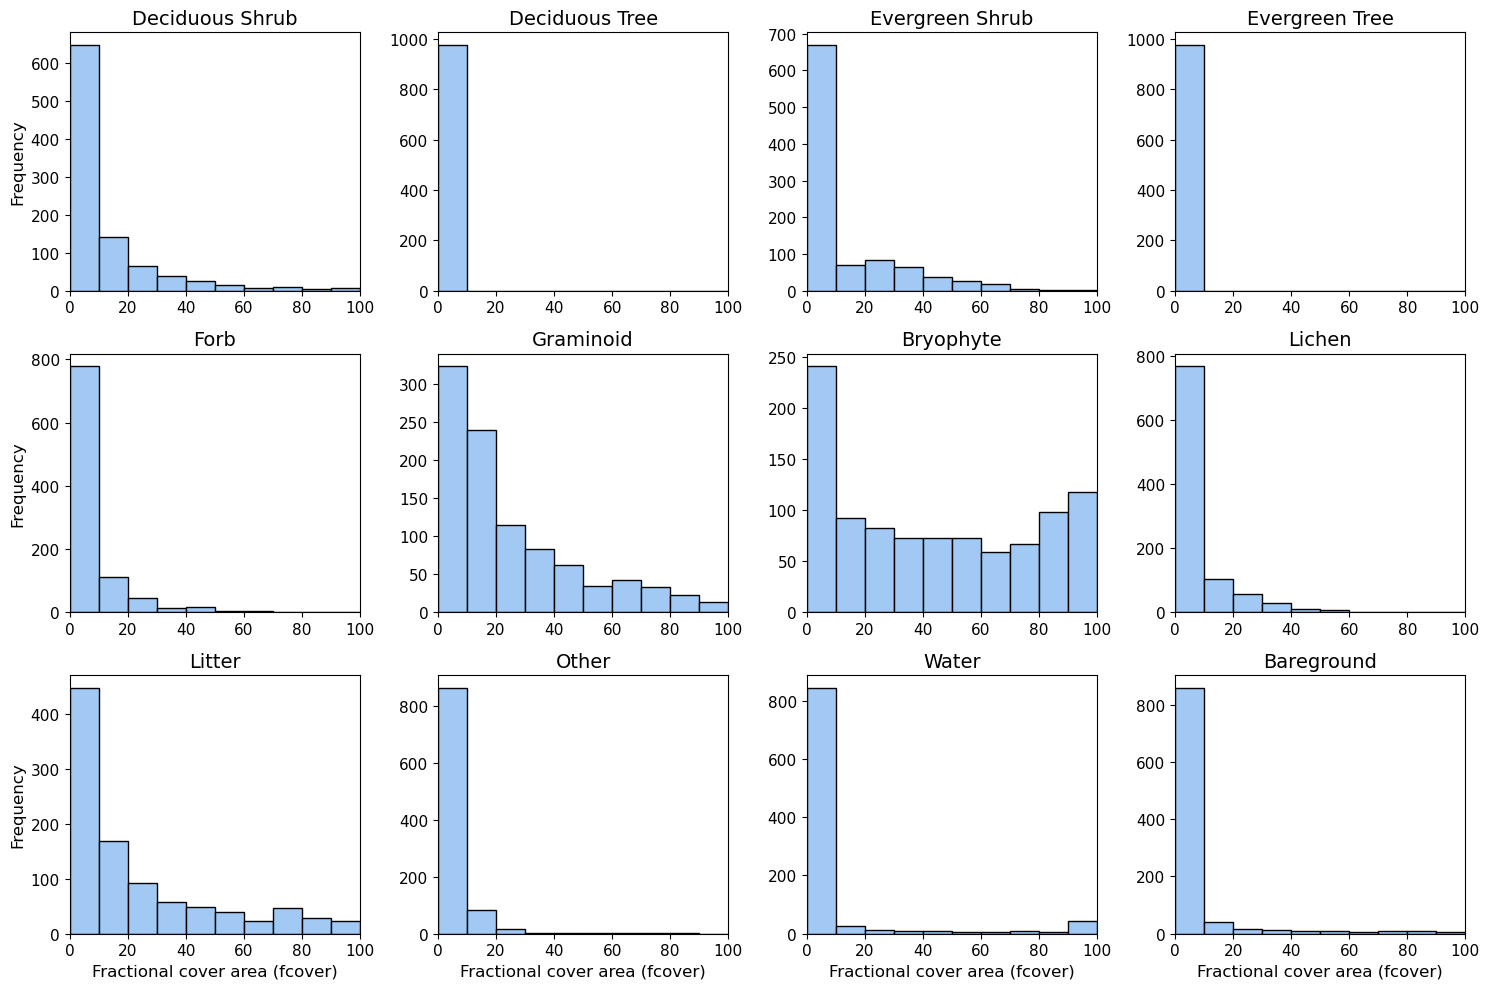

In [12]:
# List of fcover types (assuming columns represent different fcover types)
fcover_types = [col for col in pft_fcover_scaled.columns if 'cover' in col and col not in ['nonvascular_sum_cover']]

# Number of subplots (assuming 10 fcover types)
num_subplots = len(fcover_types)
nrows = 3
ncols = ceil(num_subplots / nrows)

# Determine the common x and y axis ranges
all_values = pd.concat([pft_fcover_scaled[col].dropna() for col in fcover_types])
x_min, x_max = all_values.min(), all_values.max()

# Create a figure and subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), sharex=True)

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Set Seaborn style and color palette
palette = sns.color_palette("pastel")

# Define bin edges
bin_width = 10  # Adjust as needed
# num_bins = int((x_max - x_min) / bin_width)

# Define bin edges
bin_edges = range(int(x_min), int(x_max) + bin_width, bin_width)

# Function to format fcover_type titles
def format_fcover_title(fcover_type):
    # Remove '_cover' suffix and capitalize words
    formatted_title = fcover_type.replace('_cover', '').replace('_', ' ').title()
    return formatted_title

# Plot each fcover type in a separate subplot
for i, fcover_type in enumerate(fcover_types):
    axs[i].hist(pft_fcover[fcover_type], bins=bin_edges, color=palette[0], edgecolor='black', align='mid')
    axs[i].set_title(format_fcover_title(fcover_type), fontsize=14)
    axs[i].set_xlim(x_min, x_max)
    axs[i].tick_params(axis='both', which='major', labelsize=11)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    
    # Set x-axis label only for the bottom row
    if i >= (nrows - 1) * ncols:
        axs[i].set_xlabel('Fractional cover area (fcover)', fontsize=12)
    
    # Set y-axis label only for the far-left column
    if i % ncols == 0:
        axs[i].set_ylabel('Frequency', fontsize=12)
    
# # Set y-axis limits based on the highest bin count across all subplots
# max_y = max(ax.get_ylim()[1] for ax in axs[:num_subplots])
# for ax in axs[:num_subplots]:
#     ax.set_ylim(0, max_y)

# Remove any empty subplots
for j in range(num_subplots, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
plots_w_other = len(pft_fcover_scaled[pft_fcover_scaled['other_cover'] != 0]) / len(pft_fcover_scaled)
print('Percent of plots containing "other" cover:', round(plots_w_other * 100, 2))

Percent of plots containing "other" cover: 29.96


In [14]:
non_zero_non_null_count = (pft_fcover_scaled.notnull() & (pft_fcover_scaled != 0)).sum().sum()
other_vals_per_total = len(pft_fcover_scaled[pft_fcover_scaled['other_cover'] != 0]) / non_zero_non_null_count
print('Percent of data that is "other" cover:', round(other_vals_per_total*100, 2))

Percent of data that is "other" cover: 4.55


In [15]:
pft_fcover_scaled[pft_fcover_scaled['other_cover'] != 0]['other_cover'].median()

8.98876404494382

In [16]:
bioclimate_gdf = gpd.read_file("etc/bioclim/bioclimate_la_latlon.shp")
bioclimate_gdf

,zone,Shape_Leng,Shape_Area,geometry
0,0,2.046336e+07,1.697165e+12,"POLYGON ((-43.38132 60.11147, -43.37944 60.103..."
1,1,2.252616e+07,1.946250e+11,"MULTIPOLYGON (((107.75593 77.30695, 107.75288 ..."
2,2,4.693177e+07,5.116929e+11,"MULTIPOLYGON (((113.31934 75.63689, 113.31125 ..."
3,3,7.821926e+07,1.301256e+12,"MULTIPOLYGON (((171.18156 70.06726, 171.27397 ..."
4,4,8.420476e+07,1.576037e+12,"MULTIPOLYGON (((-172.24023 60.29866, -172.2485..."
5,5,6.435929e+07,1.841596e+12,"MULTIPOLYGON (((137.26956 71.57438, 137.28616 ..."
6,6,2.178417e+06,1.128100e+10,"MULTIPOLYGON (((-163.18776 65.00010, -163.1612..."


---
# 4. Create harmonized/standardized species checklist

In [17]:
# create species name dataframe
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
species_dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_nonstandard_species_fcover.csv' 
    df = pd.read_csv(path, index_col=0)
    species_dfs.append(df)
species_fcover = pd.concat(species_dfs, axis=0)
species_fcover = species_fcover.reset_index()
species_fcover = species_fcover.rename(columns={'plotName':'unit_id',
                                                'datasetSpeciesName':'dataset_species_name',
                                                'standardHabit':'pft',
                                                'percentCover':'fcover'})
print(len(species_fcover['dataset_species_name'].unique()))
species_fcover.head(3)

2261


,unit_id,dataset_species_name,pft,fcover
0,120712b1,Litter,litter,18.54
1,120713a1,Litter,litter,77.78
2,120713b1,Litter,litter,32.67


## 4a. Load dataframe with manually assigned acceptedName

In [18]:
# load species name dataframe with corresponding accepted names
standard_species = pd.read_csv('species_standardization_mapping.csv')
standard_species

,datasetSpeciesName,acceptedName,namingAuthority
0,Juniperus communis,Juniperus communis L.,Adams 2018
1,Dicranum dispersum,Dicranum dispersum Engelm.,Afonina and Breen 2009
2,Thelypteris quelpaertensis,Oreopteris quelpaertensis (Christ) Holub,Almeida et al. 2016
3,Caloplaca holocarpa,"Athallia holocarpa (Hoffm.) Arup, Frödén & Søc...",Arup et al. 2013
4,Caloplaca ammiospila,"Blastenia ammiospila (Wahlenb.) Arup, Søchting...",Arup et al. 2013
...,...,...,...
2246,Trientalis europaea s. arctica,Trientalis europaea ssp. arctica (Fisch.) Hultén,Panarctic Flora Project Checklist
2247,Oxytropis koyukukensis,Oxytropis koyukukensis A.E. Porsild,Panarctic Flora Project Checklist
2248,Oxytropis kobukensis,Oxytropis kobukensis S.L. Welsh,NaN
2249,Lycopodium annotinum,Spinulum annotinum (L.) A. Haines,NaN


In [19]:
standard_species = standard_species.rename(columns={'datasetSpeciesName':'dataset_species_name',
                                                    'acceptedName':'accepted_species_name',
                                                    'namingAuthority':'naming_authority'})
print(len(standard_species['dataset_species_name'].unique()))
standard_species.head(3)

2251


,dataset_species_name,accepted_species_name,naming_authority
0,Juniperus communis,Juniperus communis L.,Adams 2018
1,Dicranum dispersum,Dicranum dispersum Engelm.,Afonina and Breen 2009
2,Thelypteris quelpaertensis,Oreopteris quelpaertensis (Christ) Holub,Almeida et al. 2016


## 4b. Join PFT and name source to datasetSpeciesName/AcceptedName

In [20]:
standard_species_fcover = pd.merge(left=species_fcover, right=standard_species, 
                                      left_on='dataset_species_name', right_on='dataset_species_name', 
                                      how='left')
species_pft_checklist = standard_species_fcover.drop(columns=['unit_id', 'fcover'])
species_pft_checklist = species_pft_checklist.drop_duplicates('dataset_species_name')
species_pft_checklist = species_pft_checklist.reset_index(drop=True)
species_pft_checklist = species_pft_checklist[['accepted_species_name', 'dataset_species_name', 'naming_authority', 'pft']]
species_pft_checklist = species_pft_checklist.sort_values(['accepted_species_name'])
species_pft_checklist.head(3)

,accepted_species_name,dataset_species_name,naming_authority,pft
424,Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,Flora of North America,bryophyte
1236,Acarospora schleicheri (Ach.) A. Massal.,Acarospora schleicheri,Consortium of Lichen Herbaria,lichen
1427,Achillea L.,Achillea lanulosa,Panarctic Flora Project Checklist,forb


## 4c. Add Nawrocki Checklist category and potential PFTs

In [21]:
og_checklist = pd.read_csv('etc/akveg_species_checklist.csv')

# Perform the merge
merged_df = pd.merge(left=species_pft_checklist, 
                     right=og_checklist[['Accepted Name', 'Category', 'Habit']],
                     left_on='accepted_species_name', 
                     right_on='Accepted Name', 
                     how='outer')

# Group by accepted_species_name and keep the additional columns
aggregated_df = merged_df.groupby('dataset_species_name').agg({
    'Category': lambda x: set(x.dropna()),  # Remove NaN values and aggregate to sets
    'Habit': lambda x: set(x.dropna()),
    'accepted_species_name': 'first',        # Keep the first occurrence
    'naming_authority': 'first',            # Keep the first occurrence
    'pft': 'first'                          # Keep the first occurrence
}).reset_index()

# View the final dataframe
aggregated_df = aggregated_df.rename(columns={'Category':'category', 'Habit':'habit'})
aggregated_df

,dataset_species_name,category,habit,accepted_species_name,naming_authority,pft
0,!Oncophorus demetrii,{},{},Oncophorus demetrii (Renauld & Cardot) Hedenäs,Consortium of Bryophyte Herbaria,bryophyte
1,Abietinella abietina,{moss},{moss},Abietinella abietina (Hedw.) Fleisch.,Flora of North America,bryophyte
2,Acarospora schleicheri,{lichen},{lichen},Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria,lichen
3,Achillea lanulosa,{eudicot},{forb},Achillea L.,Panarctic Flora Project Checklist,forb
4,Achillea millefolium,{eudicot},{forb},Achillea millefolium L.,Flora of North America,forb
...,...,...,...,...,...,...
2256,soil,{},{},None,None,bare ground
2257,standingDeadHerbaceous,{},{},None,None,other
2258,standingDeadWoody,{},{},None,None,other
2259,unknown,{},{},None,None,other


In [22]:
# Function to convert sets to comma-separated strings and handle empty sets
def format_set_to_string(s):
    if isinstance(s, set):
        if len(s) == 0:  # Check if the set is empty
            return ''
        else:
            return ', '.join(s)  # Convert set to comma-separated string
    return s  # If not a set, return the value as is

# Apply the function to the 'Category' and 'Habit' columns
aggregated_df['category'] = aggregated_df['category'].apply(format_set_to_string)
aggregated_df['habit'] = aggregated_df['habit'].apply(format_set_to_string)

# View the updated dataframe
aggregated_df

,dataset_species_name,category,habit,accepted_species_name,naming_authority,pft
0,!Oncophorus demetrii,,,Oncophorus demetrii (Renauld & Cardot) Hedenäs,Consortium of Bryophyte Herbaria,bryophyte
1,Abietinella abietina,moss,moss,Abietinella abietina (Hedw.) Fleisch.,Flora of North America,bryophyte
2,Acarospora schleicheri,lichen,lichen,Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria,lichen
3,Achillea lanulosa,eudicot,forb,Achillea L.,Panarctic Flora Project Checklist,forb
4,Achillea millefolium,eudicot,forb,Achillea millefolium L.,Flora of North America,forb
...,...,...,...,...,...,...
2256,soil,,,None,None,bare ground
2257,standingDeadHerbaceous,,,None,None,other
2258,standingDeadWoody,,,None,None,other
2259,unknown,,,None,None,other


In [23]:
# export
aggregated_df = aggregated_df.replace({None: -999, '':-999, np.nan:-999})
aggregated_df = aggregated_df[['accepted_species_name',
                               'dataset_species_name',
                               'naming_authority',
                               'category',
                               'habit',
                               'pft']]
aggregated_df

,accepted_species_name,dataset_species_name,naming_authority,category,habit,pft
0,Oncophorus demetrii (Renauld & Cardot) Hedenäs,!Oncophorus demetrii,Consortium of Bryophyte Herbaria,-999,-999,bryophyte
1,Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,Flora of North America,moss,moss,bryophyte
2,Acarospora schleicheri (Ach.) A. Massal.,Acarospora schleicheri,Consortium of Lichen Herbaria,lichen,lichen,lichen
3,Achillea L.,Achillea lanulosa,Panarctic Flora Project Checklist,eudicot,forb,forb
4,Achillea millefolium L.,Achillea millefolium,Flora of North America,eudicot,forb,forb
...,...,...,...,...,...,...
2256,-999,soil,-999,-999,-999,bare ground
2257,-999,standingDeadHerbaceous,-999,-999,-999,other
2258,-999,standingDeadWoody,-999,-999,-999,other
2259,-999,unknown,-999,-999,-999,other


In [24]:
aggregated_df.to_csv('species_pft_checklist.csv', index=False)

---
# 5. Create species fcover table

In [25]:
standard_species_fcover = standard_species_fcover[['unit_id', 'accepted_species_name', 'pft', 'fcover']]
standard_species_fcover

,unit_id,accepted_species_name,pft,fcover
0,120712b1,NaN,litter,18.54
1,120713a1,NaN,litter,77.78
2,120713b1,NaN,litter,32.67
3,120714a1,NaN,litter,15.23
4,120714a2,NaN,litter,84.87
...,...,...,...,...
93323,TL_WNAC7_VgComp,Drepanocladus polygamus (Schimp.) Hedenäs,bryophyte,1.00
93324,TL_WNAC7_VgComp,Blepharostoma trichophyllum (L.) Dumort.,bryophyte,1.00
93325,TL_WNAC7_VgComp,Campylophyllum sommerfeltii (Myr.) Hedenäs,bryophyte,1.00
93326,TL_WNAC7_VgComp,Scorpidium revolvens (Sw.) Hedenäs,bryophyte,1.00


In [26]:
# Group by 'plotName' and 'acceptedName' and sum the 'percentCover' values
standard_species_fcover = standard_species_fcover.groupby(['unit_id', 'accepted_species_name'], as_index=False)['fcover'].sum()
standard_species_fcover

,unit_id,accepted_species_name,fcover
0,010A,Abietinella abietina (Hedw.) Fleisch.,0.10
1,010A,Alectoria nigricans (Ach.) Nyl.,0.10
2,010A,Alopecurus borealis Trin.,0.10
3,010A,Bistorta vivipara (L.) Delarbre,0.70
4,010A,Bryum Hedw.,0.10
...,...,...,...
89027,YUK9,Populus balsamifera L.,37.50
89028,YUK9,Rosa acicularis Lindl.,15.00
89029,YUK9,Rubus idaeus L.,0.55
89030,YUK9,Tanacetum bipinnatum (L.) Sch. Bip.,0.55


In [27]:
len(standard_species_fcover['accepted_species_name'].unique())

1722

In [28]:
# Get the unique plot IDs from aux
post2010_plot_ids = aux['unit_id'].unique()

# Filter the dataframe to only include rows where plotName is in valid_plot_ids
post2010_standard_species_fcover = standard_species_fcover[standard_species_fcover['unit_id'].isin(post2010_plot_ids)]
post2010_standard_species_fcover.set_index('unit_id', inplace=True)
post2010_standard_species_fcover

,accepted_species_name,fcover
unit_id,,
120712b1,Alnus alnobetula ssp. fruticosa (Rupr.) Raus.,10.60
120712b1,Andromeda polifolia L.,0.66
120712b1,Aulacomnium turgidum (Wahlenb.) Schwägr.,3.97
120712b1,Betula nana L.,5.96
120712b1,Carex bigelowii Torr. ex Schwein.,11.26
...,...,...
TOOL_043.basePlot.div.41.4.1,Eriophorum vaginatum L.,14.00
TOOL_043.basePlot.div.41.4.1,Rhododendron tomentosum Harmaja,16.00
TOOL_043.basePlot.div.41.4.1,Rubus chamaemorus L.,37.00


In [29]:
post2010_standard_species_fcover = post2010_standard_species_fcover.replace({None: -999, '':-999, np.nan:-999})
post2010_standard_species_fcover.to_csv('synthesized_species_fcover.csv', index=True)

In [30]:
aux.columns

Index(['unit_id', 'survey_year', 'survey_month', 'survey_day', 'plot_radius',
       'latitude_y', 'longitude_x', 'georef_source', 'georef_accuracy',
       'coord_epsg', 'data_subsource', 'data_source', 'data_source_html',
       'data_subsource_citation', 'survey_method', 'fcover_scale',
       'survey_purpose', 'admin_unit', 'admin_country', 'fire_years',
       'duplicated_coords', 'duplicated_date', 'cavm_unit',
       'cavm_unit_description'],
      dtype='object')

In [31]:
temp = pd.merge(left=post2010_standard_species_fcover.reset_index(), right=aux[['unit_id','data_subsource', 'data_source']],
                left_on='unit_id', right_on='unit_id', how='left')
temp.groupby('data_subsource')['accepted_species_name'].nunique()

data_subsource
AIM NPR-A Nawrocki (pub 2020)                    376
Atqasuk Villarreal (pub 2013)                    134
Barrow DOE NGEE Sloan (pub 2014)                  47
Barrow IBP Tundra Biome Villarreal (pub 2012)     63
Flux Tower Zona Davidson (pub 2016)               74
NGEE-Arctic Amy Breen (pub 2020)                 211
Prudhoe ArcSEES road study Walker (pub 2015)      56
Prudhoe Bay Airport ArcSEES Walker (pub 2016)     45
Shell Onshore Macander (pub 2017)                351
Toolik Field Station NEON (pub 2021)              65
Utqiagvik-Barrow NEON (pub 2021)                  57
Name: accepted_species_name, dtype: int64

In [32]:
temp.groupby('data_source')['accepted_species_name'].nunique()

data_source
ABR      351
AKVEG    376
AVA      230
NEON     107
NGA      211
Name: accepted_species_name, dtype: int64

In [33]:
len(temp['accepted_species_name'].unique())

647

---
# 6. Plot overlap with CAVM zones if not in aux

In [34]:
from osgeo import gdal
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.plot import show

# Load your raster file
raster_path = 'etc/raster_cavm/raster_cavm_v1.tif'
src = rasterio.open(raster_path)

# Load points
gdf = aux_gdf.copy()
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(src.crs)

In [35]:
gdf.head(3)

,unit_id,survey_year,survey_month,survey_day,plot_radius,latitude_y,longitude_x,georef_source,georef_accuracy,coord_epsg,...,fcover_scale,survey_purpose,admin_unit,admin_country,fire_years,duplicated_coords,duplicated_date,cavm_unit,cavm_unit_description,geometry
0,120712b1,2012,7,12.0,55.0,69.362520,-152.13188,GPS,NaN,EPSG:4326,...,percent,Conduct vegetation assessments and paired remo...,Alaska,United States of America,NaN,NaN,NaN,G4,"Tussock-sedge, dwarf-shrub, moss tundra",POINT (1066879.125 -2017698.006)
1,120713a1,2012,7,13.0,55.0,70.515810,-157.26028,GPS,NaN,EPSG:4326,...,percent,Conduct vegetation assessments and paired remo...,Alaska,United States of America,NaN,NaN,"['120713a1', '120713b1']",W2,"Sedge, moss, dwarf-shrub wetland complex",POINT (833437.599 -1988523.445)
2,120713b1,2012,7,13.0,55.0,69.810196,-152.35090,GPS,NaN,EPSG:4326,...,percent,Conduct vegetation assessments and paired remo...,Alaska,United States of America,NaN,NaN,"['120713a1', '120713b1']",G3,"Non-tussock sedge, dwarf-shrub, moss tundra",POINT (1036423.707 -1978364.583)


In [36]:
gdf.total_bounds

array([  675375.16374252, -2703942.74126575,  1207305.06962302,
       -1864701.85086807])

<Axes: >

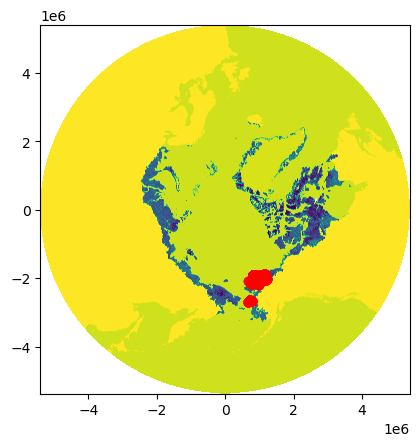

In [37]:
fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent = [gdf.total_bounds[0], gdf.total_bounds[2], gdf.total_bounds[1], gdf.total_bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax)

gdf.plot(ax=ax, color='red')

In [38]:
# sample raster at coordinates
coord_list = [(x, y) for x, y in zip(gdf['geometry'].x, gdf['geometry'].y)]
gdf['raster_value'] = [x[0] for x in src.sample(coord_list)]

In [39]:
if 'cavm_unit' not in gdf.columns.to_list():
    # Load the raster legend CSV
    legend_path = 'etc/raster_cavm/raster_cavm_legend.csv'
    legend_df = pd.read_csv(legend_path)
    
    # Ensure that 'cavm_zone' in aux_gdf and 'Raster code' in legend_df are of the same type
    gdf['raster_value'] = gdf['raster_value'].astype(str)  # Adjust type as necessary
    legend_df['Raster code'] = legend_df['Raster code'].astype(str)  # Adjust type as necessary

    # Perform the left join
    new_aux_table = gdf.merge(legend_df, left_on='raster_value', right_on='Raster code', how='left')
    new_aux_table.drop(columns=['raster_value', 'Raster code', '# Pixels', 'Area  (1000 km2)', 'Long Description', 'geometry'], inplace=True)
    new_aux_table.rename(columns={'Vegetation Unit':'cavm_unit', 'Short Description':'cavm_unit_description'}, inplace=True)
    new_aux_table = new_aux_table.set_index('unit_id')
    new_aux_table.to_csv('survey_unit_information.csv', index=True)
else:
    print('cavm_unit already present in auxiliary table.')

cavm_unit already present in auxiliary table.


In [40]:
# extract
cavm_info = gdf[['unit_id', 'geometry', 'cavm_unit', 'cavm_unit_description']]
pft_cavm = pft_fcover.merge(cavm_info, left_on='unit_id', right_on='unit_id', how='left')

/tmp/ipykernel_47803/1810211495.py:96: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


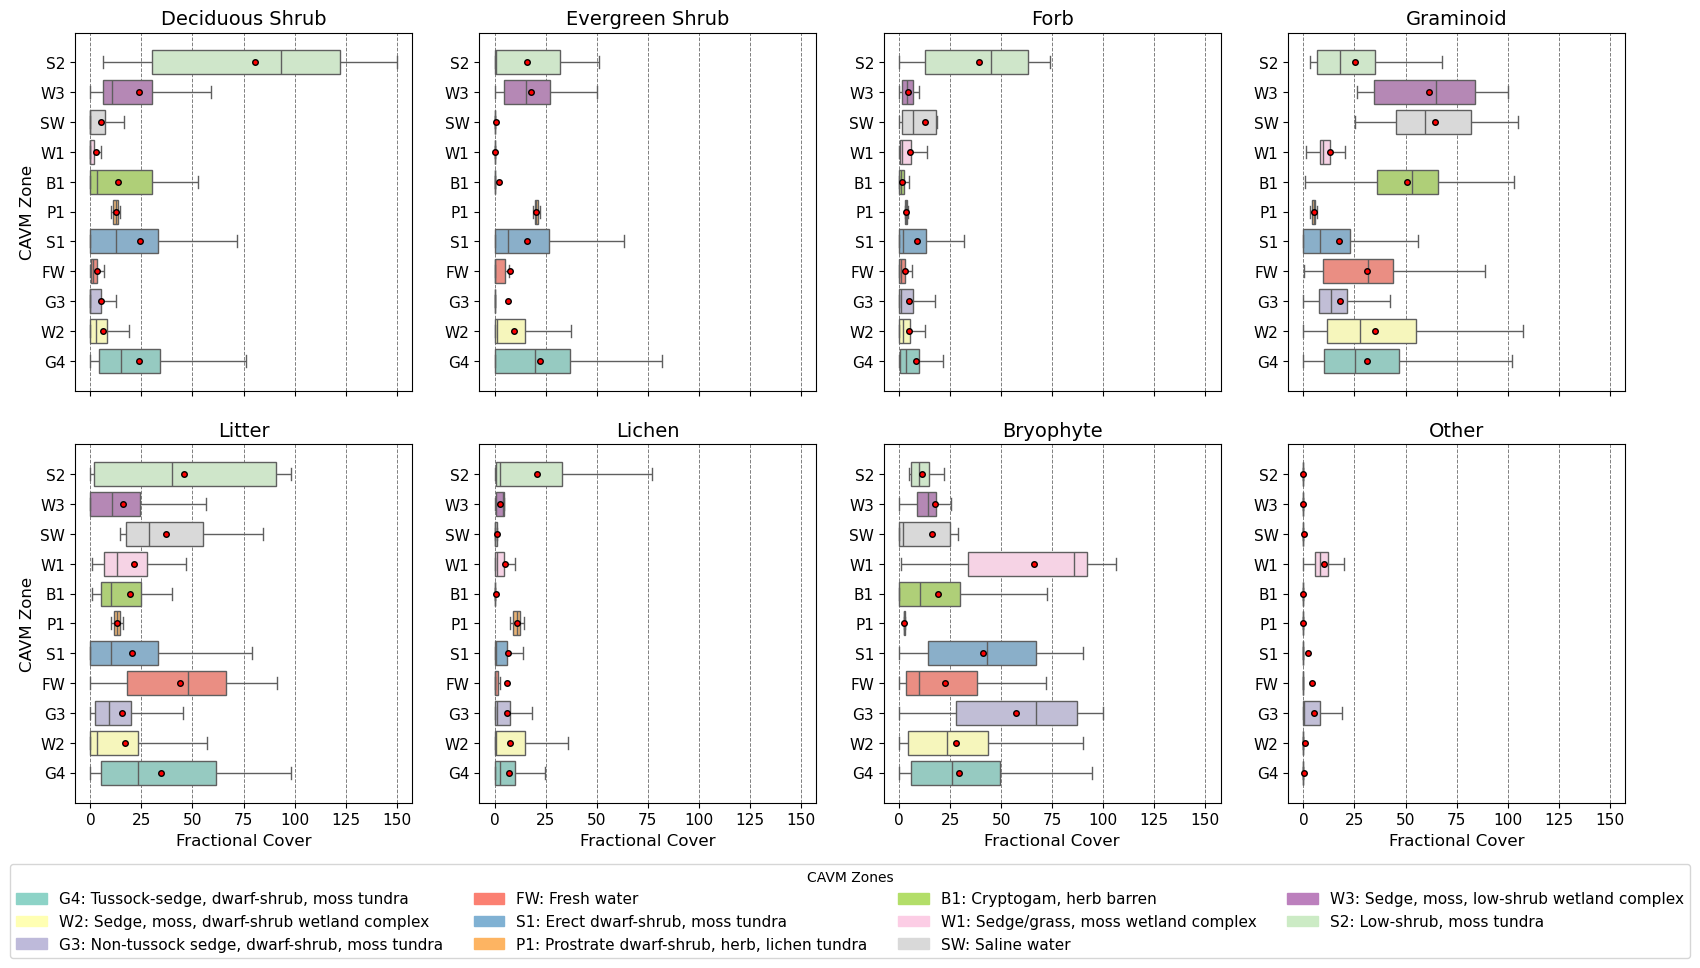

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Define the cover types to plot
cover_types = [
    'deciduous_shrub_cover',
    'evergreen_shrub_cover',
    'forb_cover',
    'graminoid_cover',
    'litter_cover',
    'lichen_cover',
    'bryophyte_cover',
    'other_cover'
]

# Melt the DataFrame to long format
melted_pft = pft_cavm.melt(id_vars=['cavm_unit', 'cavm_unit_description'], 
                            value_vars=cover_types,
                            var_name='Cover Type', 
                            value_name='Fractional Cover')

# Get unique vegetation units and their descriptions
veg_unit_info = pft_cavm[['cavm_unit', 'cavm_unit_description']].drop_duplicates()

# Create a dictionary for the color mapping
color_palette = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']
color_map = {unit: color for unit, color in zip(veg_unit_info['cavm_unit'], color_palette)}

# Set up the number of columns for the subplot grid
num_cols = 4  # Adjusting for 2 rows of 4 columns
num_units = len(cover_types)
num_rows = int(np.ceil(num_units / num_cols))

# Set up the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Create a box plot for each cover type
for i, (ax, cover_type) in enumerate(zip(axes, cover_types)):
    title = cover_type.replace('_', ' ').replace(' cover', '').title()
    
    # Filter data for the current cover type
    current_data = melted_pft[melted_pft['Cover Type'] == cover_type]
    
    sns.boxplot(
        data=current_data,
        x='Fractional Cover',
        y='cavm_unit',
        hue='cavm_unit',
        ax=ax,
        palette=color_map,
        dodge=False,
        showfliers=False,  # Optionally hide outliers
        showmeans=True, 
        meanprops={'marker':'o',
                   'markerfacecolor':'red',
                   'markeredgecolor':'black',
                   'markersize':'4'}  # Custom properties for the mean point
    )

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Fractional Cover', fontsize=12)
    
    # Set y-axis label only for the top left and bottom left subplots
    if i % num_cols == 0:  # Top left (0) and bottom left (4)
        ax.set_ylabel('CAVM Zone', fontsize=12)
    else:
        ax.set_ylabel('')  # Clear y-axis label for other subplots
    
    # Add vertical dashed grid lines
    ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='grey')

    # Get current y-limits and adjust them
    y_limits = ax.get_ylim()
    ax.set_ylim(y_limits[1] - 0.5, y_limits[0] + 0.5)  # Adjust as needed
    ax.tick_params(axis='both', which='major', labelsize=11)  # Change 12 to your desired font size

# Adjust space around the subplots
plt.subplots_adjust(hspace=0.15)  # Decrease hspace to bring rows closer together

# Create a custom legend
handles = [mpatches.Patch(color=color_map[unit], label=f"{unit}: {desc}") 
           for unit, desc in zip(veg_unit_info['cavm_unit'], veg_unit_info['cavm_unit_description'])]

# Add the legend to the bottom of the figure
plt.legend(handles=handles, title='CAVM Zones', bbox_to_anchor=(-1.3, -0.15), loc='upper center', ncol=4, fontsize=11)

# Hide any unused axes
for i in range(len(cover_types), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()